# Прогнозирование цены автомобиля (kNN)

Исследование и построение базовой модели на датасете `data.csv`. В работе последовательно выполняются разведочный анализ данных (EDA), подготовка признаков и обучение kNN-регрессора с подбором гиперпараметров.


## План

1. Загрузка и первичный осмотр данных.
2. Разведочный анализ и очистка.
3. Подготовка признаков для модели.
4. Обучение kNN и оценка качества.
5. Подбор гиперпараметров и финальная валидация.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use('seaborn-v0_8')
sns.set_palette('crest')
DATA_PATH = Path('C:/Users/w6itec6apel/predict-car-price/data.csv')


In [2]:
df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print(f"Размерность: {df.shape}")
df.head()


Размерность: (188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500


In [3]:
display(df.dtypes)
print('\nИнформация о пропусках:')
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


id               int64
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


Информация о пропусках:


clean_title    21419
fuel_type       5083
accident        2452
dtype: int64

In [4]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
id,188533.0,94266.000000,54424.933488,0.0,47133.0,94266.0,141399.0,188532.0
model_year,188533.0,2015.829998,5.660967,1974.0,2013.0,2017.0,2020.0,2024.0
milage,188533.0,65705.295174,49798.158076,100.0,24115.0,57785.0,95400.0,405000.0
price,188533.0,43878.016178,78819.522254,2000.0,17000.0,30825.0,49900.0,2954083.0


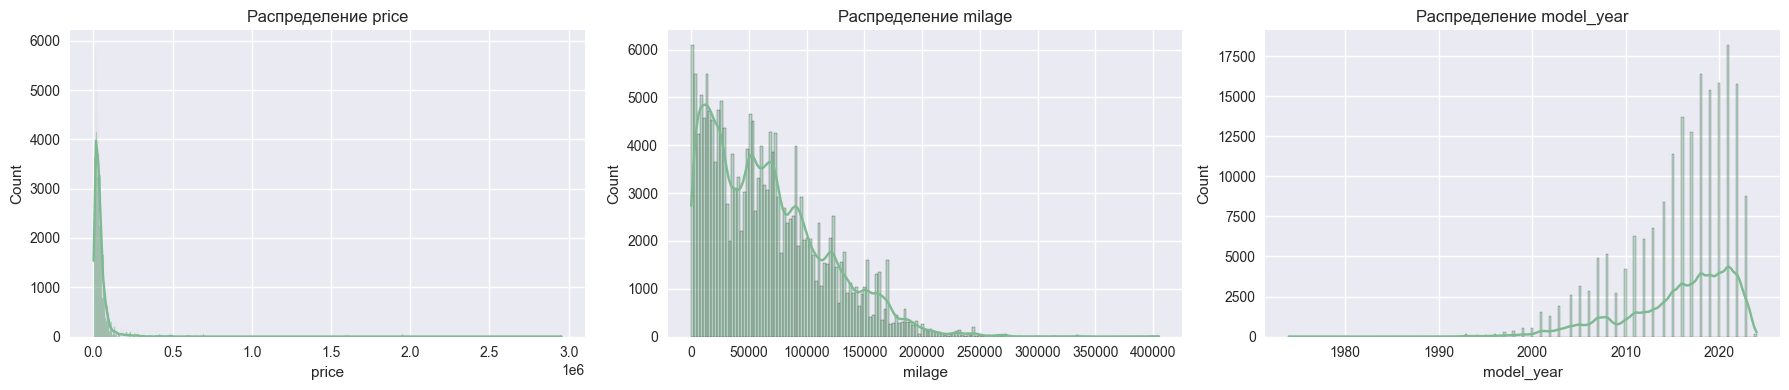

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
for ax, col in zip(axes, ['price', 'milage', 'model_year']):
    sns.histplot(data=df, x=col, kde=True, ax=ax)
    ax.set_title(f'Распределение {col}')
plt.tight_layout()


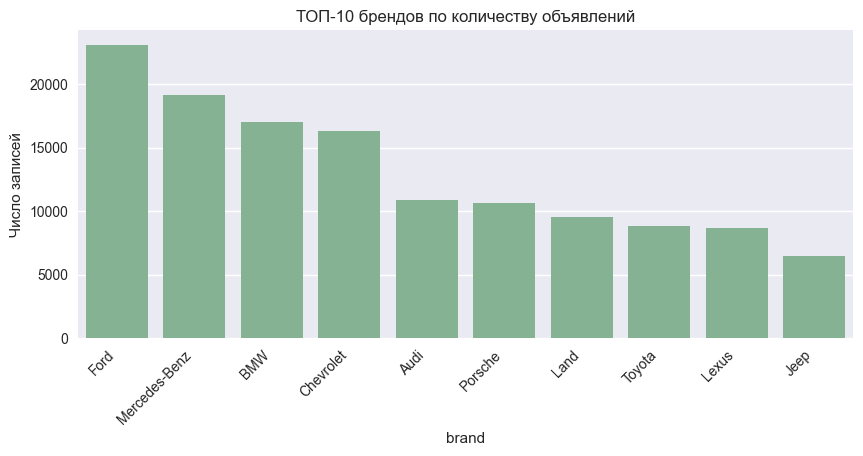

In [6]:
top_brands = df['brand'].value_counts().head(10)
plt.figure(figsize=(10, 4))
sns.barplot(x=top_brands.index, y=top_brands.values)
plt.xticks(rotation=45, ha='right')
plt.title('ТОП-10 брендов по количеству объявлений')
plt.ylabel('Число записей')
plt.show()


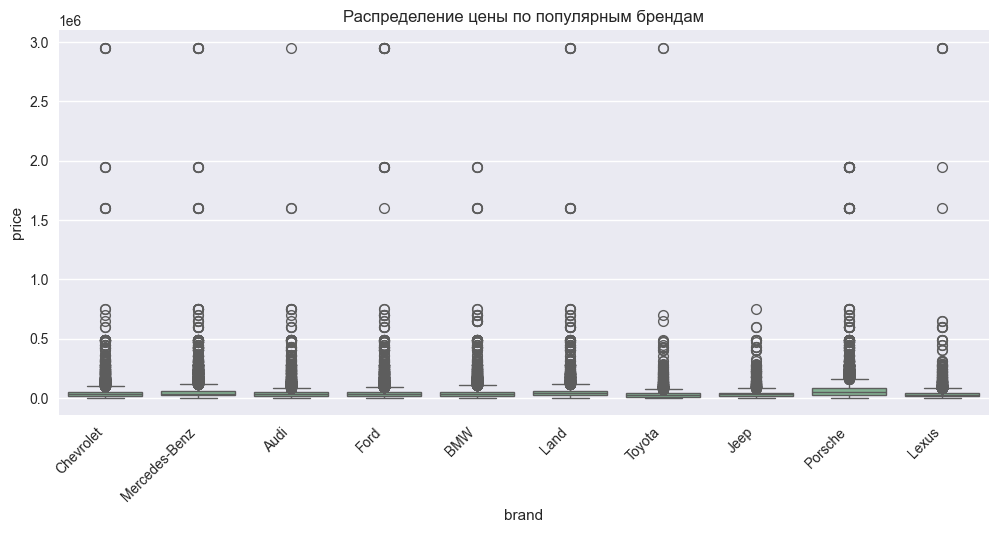

In [7]:
top_brand_names = top_brands.index.tolist()
filtered = df[df['brand'].isin(top_brand_names)]
plt.figure(figsize=(12, 5))
sns.boxplot(data=filtered, x='brand', y='price')
plt.xticks(rotation=45, ha='right')
plt.title('Распределение цены по популярным брендам')
plt.show()


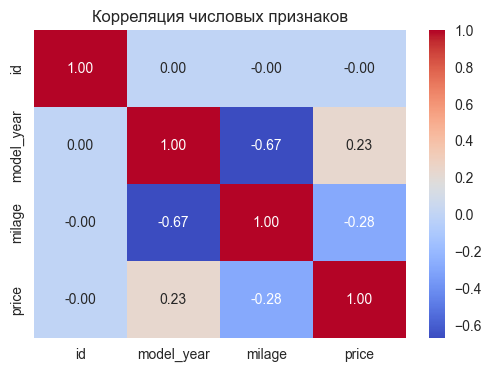

In [8]:
numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(6, 4))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляция числовых признаков')
plt.show()


## Подготовка данных

- Очистим выбросы по цене и пробегу (оставим разумные границы).
- Извлечём мощность двигателя и объём из текстового признака `engine`.
- Закодируем бинарные признаки и приведём категории к единому виду.
- Сформируем рабочий набор признаков для модели.


In [9]:
import re

# Удаляем дубликаты
before = len(df)
df = df.drop_duplicates().copy()
print(f"Удалено дубликатов: {before - len(df)}")

# Ограничения по выбросам
price_low, price_high = df['price'].quantile([0.01, 0.99])
milage_low, milage_high = df['milage'].quantile([0.01, 0.99])
df = df[(df['price'].between(price_low, price_high)) & (df['milage'].between(milage_low, milage_high))].copy()
print(f"После фильтрации: {df.shape}")

# Парсинг двигателя
def extract_hp(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'([\d\.]+)\s*HP', text)
    return float(match.group(1)) if match else np.nan


def extract_liters(text):
    if pd.isna(text):
        return np.nan
    match = re.search(r'([\d\.]+)L', text)
    return float(match.group(1)) if match else np.nan


df['engine_hp'] = df['engine'].astype(str).apply(extract_hp)
df['engine_liters'] = df['engine'].astype(str).apply(extract_liters)

# Бинарные признаки
df['had_accident'] = np.where(df['accident'].str.contains('None', case=False, na=False), 0, 1)
df['clean_title_flag'] = df['clean_title'].str.lower().isin(['yes', 'clean']).astype(int)

# Строковые столбцы приводим к нижнему регистру
df['fuel_type'] = df['fuel_type'].str.lower().fillna('unknown')
df['transmission'] = df['transmission'].str.lower().fillna('unknown')
df['brand'] = df['brand'].str.upper()

feature_candidates = ['brand', 'model_year', 'milage', 'fuel_type', 'transmission',
                      'engine_hp', 'engine_liters', 'had_accident', 'clean_title_flag']

df[feature_candidates + ['price']].head()


Удалено дубликатов: 0
После фильтрации: (181712, 13)


,brand,model_year,milage,fuel_type,transmission,engine_hp,engine_liters,had_accident,clean_title_flag,price
1,LINCOLN,2002,143250,gasoline,a/t,252.0,3.9,1,1,4999
2,CHEVROLET,2002,136731,e85 flex fuel,a/t,320.0,5.3,0,1,13900
3,GENESIS,2017,19500,gasoline,transmission w/dual shift mode,420.0,5.0,0,1,45000
4,MERCEDES-BENZ,2021,7388,gasoline,7-speed a/t,208.0,2.0,0,1,97500
5,AUDI,2018,40950,gasoline,a/t,252.0,2.0,0,1,29950


In [10]:
df[feature_candidates + ['price']].isna().sum()


brand                   0
model_year              0
milage                  0
fuel_type               0
transmission            0
engine_hp           31749
engine_liters       13497
had_accident            0
clean_title_flag        0
price                   0
dtype: int64

## Обучение модели kNN

Будем решать задачу регрессии. Для корректной работы kNN нормализуем числовые признаки, категориальные преобразуем через One-Hot. В качестве базовой метрики используем RMSE/MAE/R².


In [11]:
target = 'price'
X = df[feature_candidates].copy()
y = df[target]

numeric_features = ['model_year', 'milage', 'engine_hp', 'engine_liters', 'had_accident', 'clean_title_flag']
categorical_features = ['brand', 'fuel_type', 'transmission']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

baseline_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred) ** 0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Baseline RMSE: {rmse:,.0f}")
print(f"Baseline MAE:  {mae:,.0f}")
print(f"Baseline R²:   {r2:.3f}")


Baseline RMSE: 26,219
Baseline MAE:  14,933
Baseline R²:   0.384


In [12]:
MAX_GS_SAMPLES = 50_000
X_train_gs = X_train.copy()
y_train_gs = y_train.copy()

if len(X_train) > MAX_GS_SAMPLES:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(len(X_train), MAX_GS_SAMPLES, replace=False)
    X_train_gs = X_train.iloc[sample_idx]
    y_train_gs = y_train.iloc[sample_idx]
    print(f'Для grid search используется подвыборка: {len(X_train_gs)} записей из {len(X_train)}')
else:
    print(f'Grid search на полной выборке: {len(X_train_gs)} записей')


Для grid search используется подвыборка: 50000 записей из 145369


In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
param_grid = {
    'knn__n_neighbors': [3, 5, 7, 11, 15],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2]
}

grid_search = GridSearchCV(
    estimator=baseline_model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_gs, y_train_gs)
print('Лучшие параметры:', grid_search.best_params_)
print(f"Лучшее CV-RMSE: {-grid_search.best_score_:,.0f}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

rmse_best = mean_squared_error(y_test, y_pred_best) ** 0.5
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f"Test RMSE: {rmse_best:,.0f}")
print(f"Test MAE:  {mae_best:,.0f}")
print(f"Test R²:   {r2_best:.3f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'knn__n_neighbors': 15, 'knn__p': 2, 'knn__weights': 'uniform'}
Лучшее CV-RMSE: 25,623
Test RMSE: 25,062
Test MAE:  14,216
Test R²:   0.437


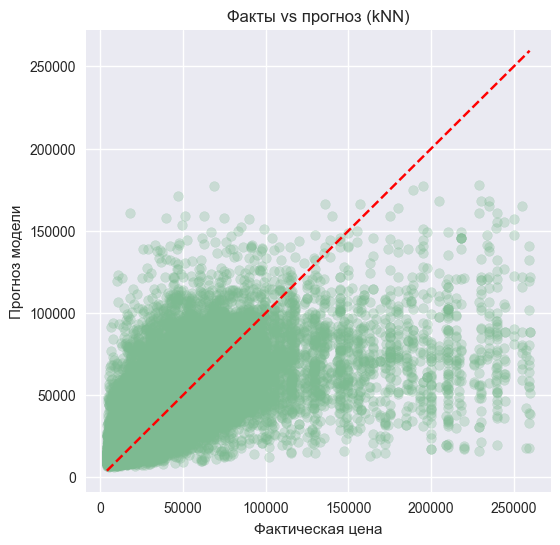

In [14]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактическая цена')
plt.ylabel('Прогноз модели')
plt.title('Факты vs прогноз (kNN)')
plt.show()


## Выводы

- Проведён полный разведочный анализ, показаны распределения и взаимосвязи ключевых признаков.
- Признаки очищены от выбросов, извлечены числовые характеристики двигателя, создана выборка для модели.
- Базовый kNN настроен в конвейере со стандартизацией и One-Hot-кодированием.
- GridSearchCV подобрал оптимальные `n_neighbors`, `weights` и `p`, получены итоговые метрики на тесте.
